# Анализ метрик сервиса по доставке продуктов
## Описание 

Вы работаете продуктовым аналитиком в компании по доставке продуктов на дом. Сервис доступен как в приложении на ios, так и на android. Вы настроили фронтовую аналитику в AppMetrica, и в конце квартала маркетинг-менеджер попросил вас проанализировать поведение пользователей, а также оценить эффективность каналов их привлечения.   
### Описание данных   

- `date` – дата совершения события
- `event` - событие:
 * app_install – установка приложения
 * app_start – открыть приложения
 * register – зарегистрироваться 
 * search – перейти на страницу поиска товаров (каталог)
 * open_item – открыть товар
 * choose_item – отправить товар в корзину
 * tap_basket – перейти в корзину
 * purchase – подтверждение покупки
- `gender` – пол пользователя
- `os_name` – платформа пользователя
- `city` – город пользователя
- `device_id` – идентификатор устройства пользователя
- `urm_source` – канал, с которого пришел пользователь
- `purchase_sum` – стоимость покупки (при совершении события ‘purchase’)


### План работы:    
1. EDA     
2. Анализ MAU  
3. Определение DAU  
4. Распределение покупок по дням недели  
5. CR в повторную покупку в течение месяца - лучше всего отражает нравится ли продукт пользователям    
6. Сколько пользователей пришло с разных платных каналов  
7. Анализ воронки 
8. Где самая низкая конверсия в первую покупку  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

## EDA

In [2]:
# Функция для извлечения таблиц с яндекс диска.
def open_df (public_key):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
  
    return download_url

In [3]:
df = pd.read_csv(open_df('https://disk.yandex.ru/d/p_UjGG_Dv8CE5Q'), sep=',')
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source
0,2020-01-01,app_start,NaN,android,669460,female,Moscow,-
1,2020-01-01,app_start,NaN,ios,833621,male,Moscow,vk_ads
2,2020-01-01,app_start,NaN,android,1579237,male,Saint-Petersburg,referal
3,2020-01-01,app_start,NaN,android,1737182,female,Moscow,facebook_ads
4,2020-01-01,app_start,NaN,ios,4029024,female,Moscow,facebook_ads


In [4]:
# информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747968 entries, 0 to 2747967
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   date          object 
 1   event         object 
 2   purchase_sum  float64
 3   os_name       object 
 4   device_id     int64  
 5   gender        object 
 6   city          object 
 7   utm_source    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 167.7+ MB


In [5]:
# приведение даты к нужному формату
df['date'] = pd.to_datetime(df['date'])

In [6]:
# наличие пустых значений
df.isna().sum()

date                  0
event                 0
purchase_sum    2606585
os_name               0
device_id             0
gender                0
city                  0
utm_source            0
dtype: int64

In [7]:
# замена пустых значений на 0
df.fillna(0, inplace=True)

In [8]:
# наличие дубликатов
df.duplicated().sum()

0

In [9]:
# сколько у нас уникальных пользователей
df.device_id.nunique()

190884

In [10]:
# какое распределение пользователей по источникам
df.utm_source.value_counts()

utm_source
-                610458
vk_ads           418456
yandex-direct    390232
instagram_ads    382891
google_ads       374257
facebook_ads     336953
referal          234721
Name: count, dtype: int64

Text(0, 0.5, 'Источники')

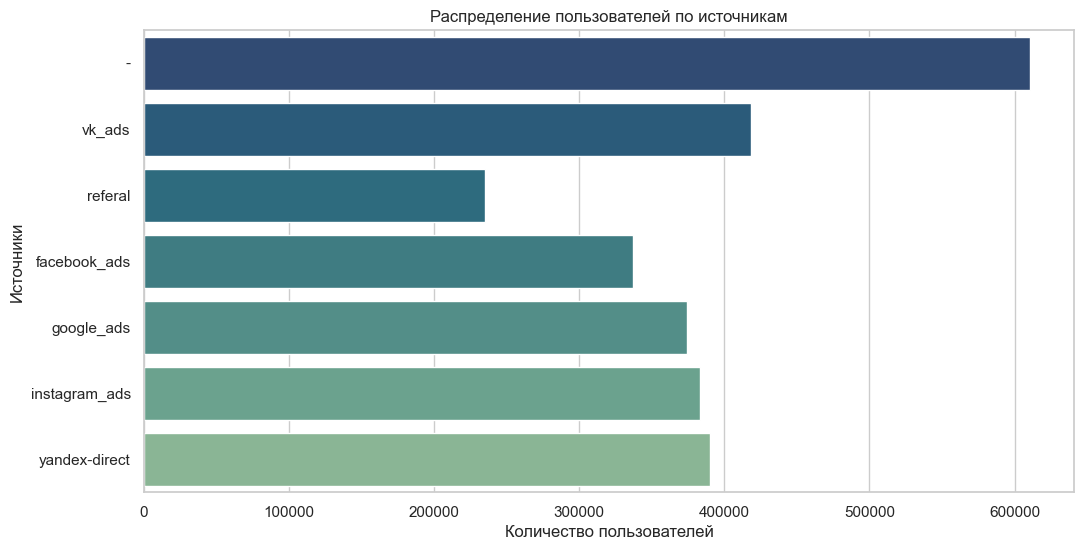

In [60]:
sns.countplot(data=df, y="utm_source", palette="crest_r")
plt.title('Распределение пользователей по источникам')
plt.xlabel('Количество пользователей')
plt.ylabel('Источники')

## Анализ метрик 
Определение MAU — количество уникальных пользователей, которые зашли в приложение в течение месяца.

In [12]:
# находим месяц
df["month"] = df["date"].dt.to_period("M")
df.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01
1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads,2020-01
2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal,2020-01
3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads,2020-01
4,2020-01-01,app_start,0.0,ios,4029024,female,Moscow,facebook_ads,2020-01


In [13]:
mau = df\
    .groupby('month', as_index=False)\
    .agg({'device_id':'nunique'})
mau

,month,device_id
0,2020-01,99161
1,2020-02,75032
2,2020-03,74623


Показатель постепенно снижается.

DAU - посмотрим на дневную активность пользователей

In [14]:
dau = df\
    .query('event == "app_start"')\
    .groupby('date', as_index=False)\
    .agg({'device_id':'nunique'})
dau.head()

,date,device_id
0,2020-01-01,4445
1,2020-01-02,5101
2,2020-01-03,5144
3,2020-01-04,4924
4,2020-01-05,5607


Text(0, 0.5, 'Количество пользователей')

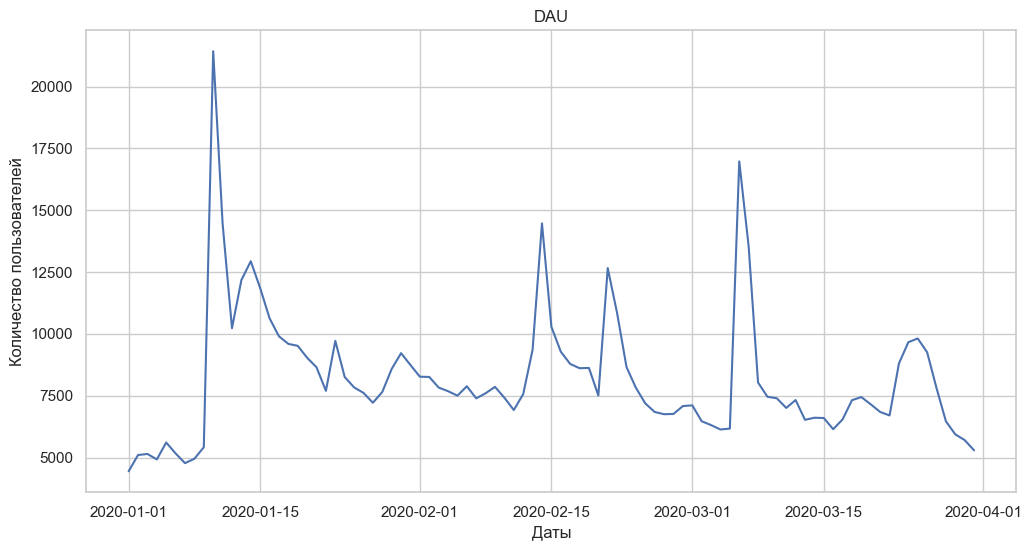

In [15]:
sns.lineplot(data=dau, x="date", y="device_id")
plt.title('DAU')
plt.xlabel('Даты')
plt.ylabel('Количество пользователей')

Посмотрим на распределение покупок по дням недели

In [16]:
df_copy = df

In [17]:
# определяем день недели 
df_copy["weekday"] = df_copy["date"].dt.day_name()
df_copy.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,weekday
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01,Wednesday
1,2020-01-01,app_start,0.0,ios,833621,male,Moscow,vk_ads,2020-01,Wednesday
2,2020-01-01,app_start,0.0,android,1579237,male,Saint-Petersburg,referal,2020-01,Wednesday
3,2020-01-01,app_start,0.0,android,1737182,female,Moscow,facebook_ads,2020-01,Wednesday
4,2020-01-01,app_start,0.0,ios,4029024,female,Moscow,facebook_ads,2020-01,Wednesday


In [61]:
# сгруппируем покупки по дням недели
day_purchase = df\
    .query('event == "purchase"')\
    .groupby('weekday', as_index=False)\
    .agg({'device_id':'nunique'})
day_purchase

,weekday,device_id
0,Friday,20321
1,Monday,15824
2,Saturday,18380
3,Sunday,15704
4,Thursday,15940
5,Tuesday,15801
6,Wednesday,15578


Text(0, 0.5, 'Количество пользователей')

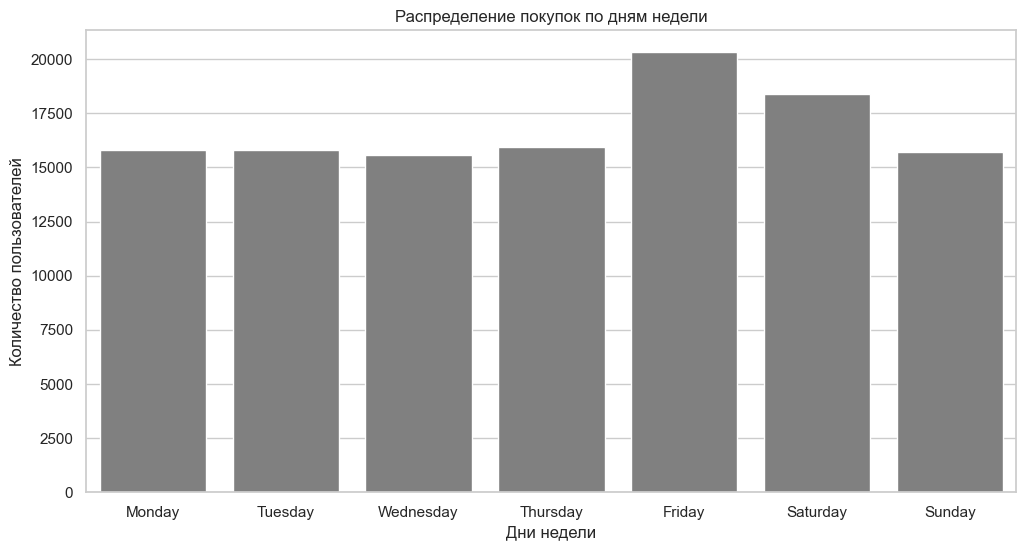

In [19]:
sns.barplot(data=day_purchase, x='weekday', y='device_id',
        order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
               'Sunday'], color="Grey")
plt.title('Распределение покупок по дням недели')
plt.xlabel('Дни недели')
plt.ylabel('Количество пользователей')

Больше всего покупок пользователи осуществляют в пятницу и субботу.

Определение CR в повторную покупку в течение месяца

In [20]:
# определим дату первой покупки 
df1 = df\
    .query('event == "purchase"')\
    .groupby('device_id', as_index=False)\
    .agg({'date': 'min'})\
    .rename(columns={'date': 'buy_date'})
df1.head(3)

,device_id,buy_date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07


In [21]:
# добавим дату первой покупки к данным
df_merged = df.merge(df1, how='inner', on='device_id')
df_merged.head(1)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,weekday,buy_date
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01,Wednesday,2020-01-07


In [22]:
# определим промежуток дней между установкой и датой первой покупки
installs = df_merged.query('event == "app_install"')
installs['days'] = installs['buy_date'] - installs['date']
installs.head(1)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,weekday,buy_date,days
46,2020-01-01,app_install,0.0,android,669460,female,Moscow,-,2020-01,Wednesday,2020-01-07,6 days


In [23]:
# отберем покупателей в первые 30 дней
final = installs.query('days <= "30 days"')
final.head()

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,weekday,buy_date,days
46,2020-01-01,app_install,0.0,android,669460,female,Moscow,-,2020-01,Wednesday,2020-01-07,6 days
163,2020-01-01,app_install,0.0,ios,833621,male,Moscow,vk_ads,2020-01,Wednesday,2020-01-01,0 days
233,2020-01-01,app_install,0.0,android,5148476,male,Saint-Petersburg,-,2020-01,Wednesday,2020-01-24,23 days
462,2020-01-01,app_install,0.0,android,8383386,female,Saint-Petersburg,vk_ads,2020-01,Wednesday,2020-01-23,22 days
516,2020-01-01,app_install,0.0,android,8581267,female,Saint-Petersburg,google_ads,2020-01,Wednesday,2020-01-13,12 days


In [24]:
# купили в первые 30 дней 
buy_first_30_days = final.groupby('date', as_index=False)\
    .agg({'device_id': 'count'})\
    .rename(columns={'device_id': 'buy_first_30_days'})
buy_first_30_days.head()

,date,buy_first_30_days
0,2020-01-01,2085
1,2020-01-02,1769
2,2020-01-03,1227
3,2020-01-04,902
4,2020-01-05,806


In [25]:
# всего установили в конкретный день 
inst_date1 = df.query('event == "app_install"')\
    .groupby('date', as_index=False)\
    .agg({'device_id': 'count'})
inst_date1.head()

,date,device_id
0,2020-01-01,3579
1,2020-01-02,3144
2,2020-01-03,2402
3,2020-01-04,1831
4,2020-01-05,1671


In [26]:
# объединим данные и посчитаем конверсию
merged = inst_date1.merge(buy_first_30_days, how='inner', on='date')
merged['cr'] = (merged['buy_first_30_days'] / merged['device_id']) * 100
merged.head()

,date,device_id,buy_first_30_days,cr
0,2020-01-01,3579,2085,58.256496
1,2020-01-02,3144,1769,56.265903
2,2020-01-03,2402,1227,51.082431
3,2020-01-04,1831,902,49.262698
4,2020-01-05,1671,806,48.234590


Text(0, 0.5, 'Количество пользователей')

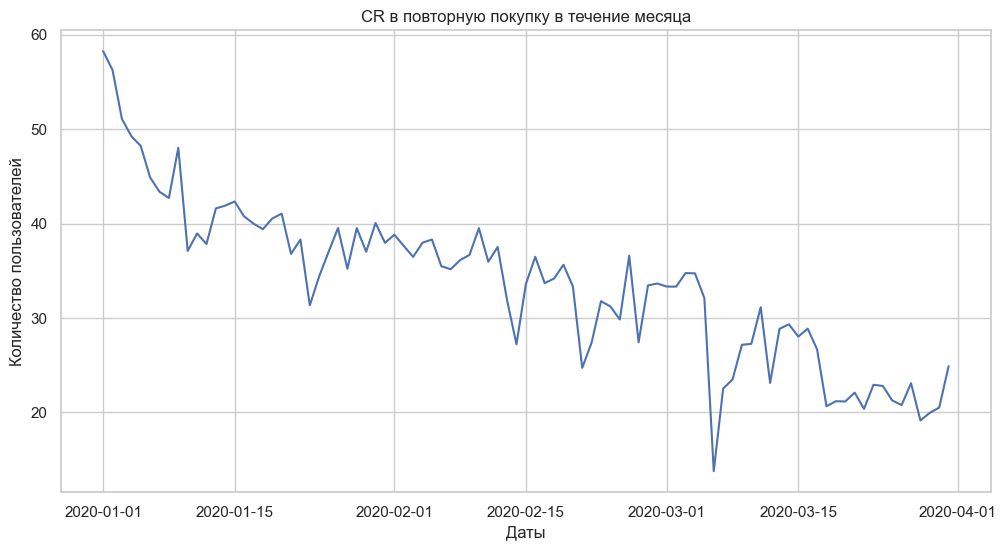

In [27]:
sns.lineplot(data=merged, x="date", y="cr")
plt.title('CR в повторную покупку в течение месяца')
plt.xlabel('Даты')
plt.ylabel('Количество пользователей')

Постепенное снижение конверсии

Определим, с какого платного маркетингового канала пришло больше всего новых пользователей

In [28]:
utm = df.query('event == "app_install"')\
    .groupby('utm_source', as_index=False)\
    .agg({'device_id': 'count'})\
    .sort_values('device_id', ascending=False)
utm

,utm_source,device_id
0,-,32460
6,yandex-direct,29368
2,google_ads,26286
5,vk_ads,23189
3,instagram_ads,20096
1,facebook_ads,13916
4,referal,9282


Больше всего новых пользователей пришло с канала Яндекс-директ

## Анализ воронки
Определим, на каком этапе воронки отваливается бОльшая часть клиентов. Посмотрим отдельно сценарии для зарегистрированных и для незарегистрированных пользователей. 

In [31]:
sales_funnel = df\
    .query('event == "register"')\
    .groupby('device_id', as_index=False)\
    .agg({'date': 'min'})\
    .rename(columns={'date': 'register_date'})
sales_funnel.head()

,device_id,register_date
0,4014,2020-02-01
1,4046,2020-01-04
2,4060,2020-03-07
3,4067,2020-01-31
4,4120,2020-01-07


In [32]:
with_register = df.merge(sales_funnel, how='left', on='device_id')
with_register.head(1)

,date,event,purchase_sum,os_name,device_id,gender,city,utm_source,month,weekday,register_date
0,2020-01-01,app_start,0.0,android,669460,female,Moscow,-,2020-01,Wednesday,2020-01-07


In [33]:
with_register.register_date.isna().sum()

542002

In [34]:
with_register['is_registered'] = np.where(with_register['date'] >= with_register['register_date'], 'yes', 'no')

In [35]:
all_events = with_register\
    .groupby(['event', 'is_registered'], as_index=False)\
    .agg({'device_id': 'count'})

all_events

,event,is_registered,device_id
0,app_install,no,112149
1,app_install,yes,42448
2,app_start,no,228951
3,app_start,yes,519754
4,choose_item,no,145886
5,choose_item,yes,392783
6,purchase,yes,141383
7,register,yes,78310
8,search,no,213228
9,search,yes,495411


Text(0, 0.5, 'Количество пользователей')

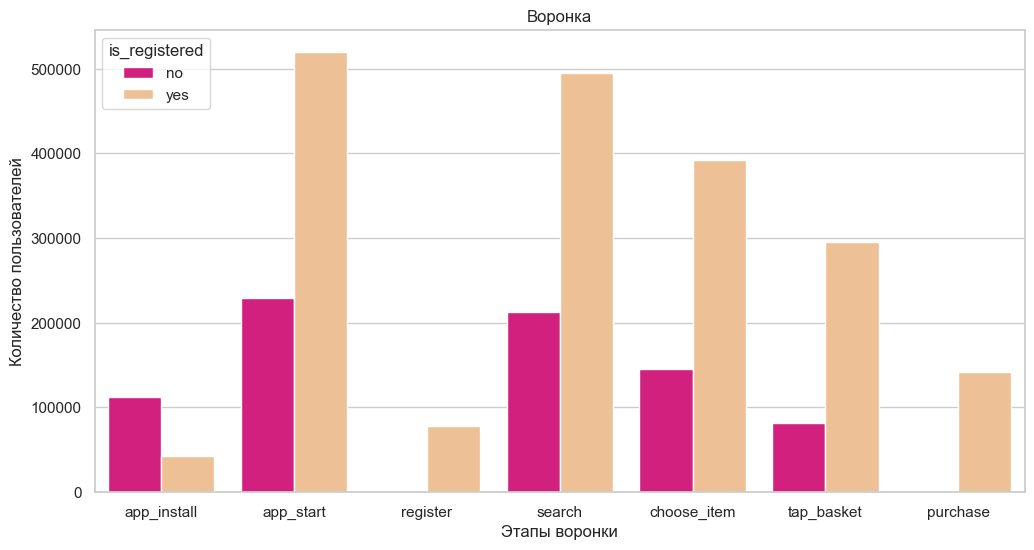

In [36]:
sns.barplot(data=all_events, x="event", y="device_id", hue='is_registered', palette='Accent_r',
           order=['app_install', 'app_start', 'register', 'search', 'choose_item', 'tap_basket', 'purchase'])
plt.title('Воронка')
plt.xlabel('Этапы воронки')
plt.ylabel('Количество пользователей')

Зарегистрированные пользователи

In [37]:
first_reg = df[df['event'] == 'register'].sort_values('date')
df['first_reg'] = df['device_id'].map(first_reg.set_index('device_id')['date'])

In [38]:
already_reg = df[df['first_reg'] < df['date']]\
    .groupby('event', as_index=False)\
    .agg({'device_id': 'nunique'})
already_reg

,event,device_id
0,app_start,40991
1,choose_item,37926
2,purchase,24880
3,search,40482
4,tap_basket,34517


<Axes: xlabel='event', ylabel='device_id'>

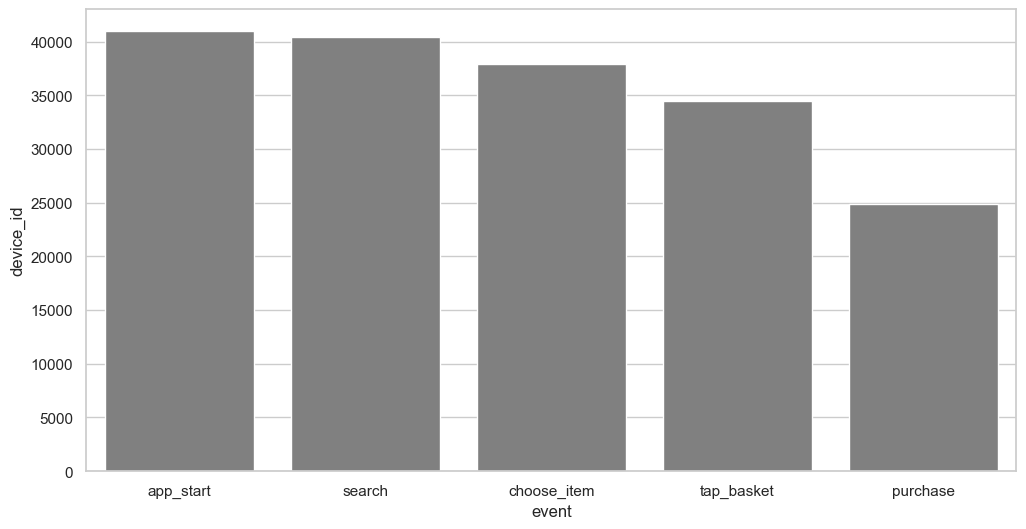

In [39]:
sns.barplot(data=already_reg, x="event", y="device_id", color='Grey',
            order=['app_start', 'search', 'choose_item', 'tap_basket', 'purchase'])

In [40]:
print('Конверсия в поиск из открытия', round((40482 / 40991) * 100, 2))

Конверсия в поиск из открытия 98.76


In [41]:
print('Конверсия в добавление товара из поиска', round((37926 / 40482) * 100, 2))

Конверсия в добавление товара из поиска 93.69


In [42]:
print('Конверсия в переход в корзину из добавления товара', round((34517 / 37926) * 100, 2))

Конверсия в переход в корзину из добавления товара 91.01


In [43]:
print('Конверсия в покупку из перехода в корзину', round((24880 / 34517) * 100, 2))

Конверсия в покупку из перехода в корзину 72.08


Наименьшая конверсия - из перехода в корзину в покупку.

Пользователи, пришедшие с каких каналов, показали самую низкую конверсию в первую покупку?

In [44]:
# пользователи, впервые открывшие
start_utm = df.query('event == "app_start"')\
    .groupby('utm_source', as_index=False)\
    .agg({'device_id': 'nunique'})\
    .rename(columns={'device_id': 'first_open'})\
    .sort_values('first_open', ascending=False)
start_utm

,utm_source,first_open
0,-,52268
6,yandex-direct,40707
2,google_ads,38092
5,vk_ads,34079
3,instagram_ads,31045
1,facebook_ads,25957
4,referal,15924


In [45]:
buy_utm = df.query('event == "purchase"')\
    .groupby('utm_source', as_index=False)\
    .agg({'device_id': 'nunique'})\
    .sort_values('device_id', ascending=False)
buy_utm

,utm_source,device_id
0,-,16598
5,vk_ads,12364
6,yandex-direct,12028
2,google_ads,11339
3,instagram_ads,10762
1,facebook_ads,9017
4,referal,6362


In [59]:
merge_utm = start_utm.merge(buy_utm, how='left', on='utm_source')
merge_utm

,utm_source,first_open,device_id
0,-,52268,16598
1,yandex-direct,40707,12028
2,google_ads,38092,11339
3,vk_ads,34079,12364
4,instagram_ads,31045,10762
5,facebook_ads,25957,9017
6,referal,15924,6362


In [47]:
merge_utm['cr'] = ((merge_utm['device_id'] / merge_utm['first_open']) * 100).round(2)
merge_utm

,utm_source,first_open,device_id,cr
0,-,52268,16598,31.76
1,yandex-direct,40707,12028,29.55
2,google_ads,38092,11339,29.77
3,vk_ads,34079,12364,36.28
4,instagram_ads,31045,10762,34.67
5,facebook_ads,25957,9017,34.74
6,referal,15924,6362,39.95


In [55]:
merge_utm['cr'].min()


29.55

In [57]:
min_cr = merge_utm.query('cr == 29.55').utm_source
print(f'Самую низкую конверсию в первую покупку показали пользователи, пришедшие с канала {min_cr}.')

Самую низкую конверсию в первую покупку показали пользователи, пришедшие с канала 1    yandex-direct
Name: utm_source, dtype: object.


## Заключение: 
1. В результате предобработки был изменен формат даты, пустые значения заменены на 0  
2. Анализ MAU выявил постепенное снижение метрики в течение 3 месяцев  
3. Дневная активность пользователей также постепенно снижалась, однако выявлялись пики активности, чаще всего товары покупали по пятницам  
4. Наибольшая конверсия в первую покупку наблюдается у пользователей, зарегистрированных 1 января 2020 года  
5. Больше всего новых пользователей пришло с платного канала - Яндекс-директ    
6. В результате анализа воронки было выявлено, что большая часть пользователей "отваливается" на этапе перехода в корзину  
7. Самую низкую конверсию в первую покупку показали пользователи, пришедшие из Яндекса  